In [1]:
import numpy as np
w=np.array([2,1,5,3])
x=np.array([2,8,3,7,1,2,0,4,5])

In [2]:
w_r=np.flip(w)
print(w_r)

[3 5 1 2]


In [3]:
w_r=w[::-1]
print(w_r)

[3 5 1 2]


In [4]:
from scipy.signal import convolve
#합성곱
convolve(x,w,mode='valid')

array([63, 48, 49, 28, 21, 20])

In [5]:
#교차 상관: 합성곱과 동일한 방식의 연산이지만, 미끄러지는 배열을 뒤집지 않는다
from scipy.signal import correlate
correlate(x,w,mode='valid')

array([48, 57, 24, 25, 16, 39])

In [6]:
correlate(x,w,mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [7]:
correlate(x,w,mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [8]:
x=np.array([[1,2,3],
           [4,5,6],
           [7,8,9]])
w=np.array([[2,0],[0,0]])
from scipy.signal import correlate2d
correlate2d(x,w,mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [9]:
correlate2d(x,w,mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [10]:
import tensorflow as tf
x_4d=x.astype(np.float).reshape(1,3,3,1)
x_4d

array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]])

In [11]:
w_4d=w.reshape(2,2,1,1)
w_4d

array([[[[2]],

        [[0]]],


       [[[0]],

        [[0]]]])

In [12]:
c_out=tf.nn.conv2d(x_4d, w_4d,strides=1, padding='SAME') #다차원 배열로 출력, 여기서는 4차원 배열

In [13]:
c_out.numpy().reshape(3,3) #배치차원과 컬러차원 제거하고, (3,3)크기로 변경하여 출력

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [14]:
x=np.array([[1,2,3,4],
           [5,6,7,8],
           [9,10,11,12],
           [13,14,15,16]])
x=x.reshape(1,4,4,1)

In [15]:
p_out=tf.nn.max_pool2d(x,ksize=2,strides=2, padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [16]:
def relu(x): #합성곱 신경망에서 자주 사용하는 활성화 함수
    return np.maximum(x,0)
x=np.array([-1,2,-3,4,-5])
relu(x)

array([0, 2, 0, 4, 0])

In [17]:
r_out=tf.nn.relu(x) #tensorflow가 제공하는 렐루 함수는 tensor객체로 반환해주기 때문에
r_out.numpy() #화면에 출력하려면 넘파이로 변환해야함

array([0, 2, 0, 4, 0])

In [18]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [19]:
class ConvolutionNetwork:
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels      # 합성곱의 커널 개수
        self.kernel_size = 3            # 커널 크기
        self.optimizer = None          # 옵티마이저
        self.conv_w = None             # 합성곱층의 가중치
        self.conv_b = None             # 합성곱층의 절편
        self.units = units             # 은닉층의 뉴런 개수
        self.batch_size = batch_size   # 배치 크기
        self.w1 = None                # 은닉층의 가중치
        self.b1 = None                # 은닉층의 절편
        self.w2 = None                # 출력층의 가중치
        self.b2 = None                # 출력층의 절편
        self.a1 = None                # 은닉층의 활성화 출력
        self.losses = []              # 훈련 손실
        self.val_losses = []          # 검증 손실
        self.lr = learning_rate       # 학습률
    # 합성곱 신경망의 정방향 계산 구현하기
    def forpass(self,x):
        # 3X3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x,self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 함수를 적용합니다.
        r_out=tf.nn.relu(c_out)
        # 2X2 최대 풀링을 적용합니다.
        p_out=tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out=tf.reshape(p_out, [x.shape[0],-1])
        z1 = tf.matmul(f_out, self.w1)+self.b1  # 첫번째 층의 선형식을 계산합니다.
        a1 = tf.nn.relu(z1)                      # 활성화 함수를 적용합니다.
        z2 = tf.matmul(a1, self.w2) + self.b2   # 두번째 층의 선형식을 계산합니다.
        return z2
    def init_weights(self, input_shape, n_classes):
        g=tf.initializers.glorot_uniform()
        self.conv_w=tf.Variable(g((3,3,1, self.n_kernels)))
        self.conv_b=tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features=14*14*self.n_kernels
        self.w1=tf.Variable(g((n_features, self.units)))      # (특성 개수, 은닉층의 크기)
        self.b1=tf.Variable(np.zeros(self.units),dtype=float) # 은닉층의 크기
        self.w2=tf.Variable(g((self.units, n_classes)))         # (은닉층의 크기, 클래스 개수)
        self.b2=tf.Variable(np.zeros(n_classes),dtype=float)  # 클래스 개수
    # 옵티마이저 객체를 만들어 가중치 초기화하기
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니 배치를 순환합니다.
            batch_losses=[]
            for x_batch, y_batch in self.gen_batch(x,y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균 내어 훈련 손실값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))
    # 미니 배치 제너레이터 함수
    def gen_batch(self, x, y): 
        bins = len(x)//self.batch_size                     # 미니 배치 함수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end]              # batch_size만큼 슬라이싱하여 반환합니다.
    # 합성곱 신경망의 역방향 계산 구현하기
    def training(self, x,y):
        m = len(x)               # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z=self.forpass(x)    # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y,z)
            loss = tf.reduce_mean(loss)
        weights_list=[self.conv_w,self.conv_b,
                                 self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그레디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(),axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x)==np.argmax(y,axis=1))
    def get_loss(self,x,y):
        z=self.forpass(x)                  # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
        return loss.numpy()

In [20]:
x= tf.Variable(np.array([1.0,2.0,3.0]))
with tf.GradientTape() as tape:
    y= x**3+2*x+5
    
#그레이디언트 계산
print(tape.gradient(y,x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [21]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                 stratify=y_train_all, test_size=0.2,
                                                 random_state=42)

In [23]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [24]:
x_train=x_train.reshape(-1,28,28,1)
x_val=x_val.reshape(-1,28,28,1)

In [25]:
x_train.shape

(48000, 28, 28, 1)

In [26]:
#정규화 작업
x_train=x_train/225 #이미지 데이터는 픽셀마다 0에서 225사이의 값을 가지기 때문에
x_val=x_val/225

In [27]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

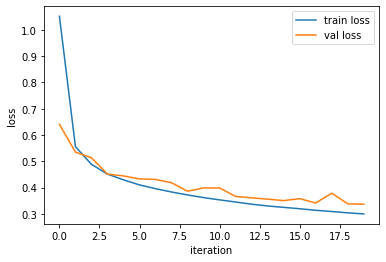

In [28]:
import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

In [29]:
cn.score(x_val, y_val_encoded)

0.8840833333333333

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [31]:
conv1=tf.keras.Sequential()
conv1.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))

In [32]:
conv1.add(MaxPooling2D((2,2)))

In [33]:
conv1.add(Flatten())

In [34]:
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [35]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [36]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history=conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5960 - accuracy: 0.7908 - val_loss: 0.3255 - val_accuracy: 0.8859
Epoch 2/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3160 - accuracy: 0.8860 - val_loss: 0.2816 - val_accuracy: 0.9011
Epoch 3/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2642 - accuracy: 0.9036 - val_loss: 0.2736 - val_accuracy: 0.9010
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2302 - accuracy: 0.9161 - val_loss: 0.2553 - val_accuracy: 0.9108
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2041 - accuracy: 0.9243 - val_loss: 0.2707 - val_accuracy: 0.9045
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1934 - accuracy: 0.9270 - val_loss: 0.2537 - val_accuracy: 0.9110
Epoch 7/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1651 - accuracy: 0.9401 - val_loss: 0.2531 - val_accuracy:

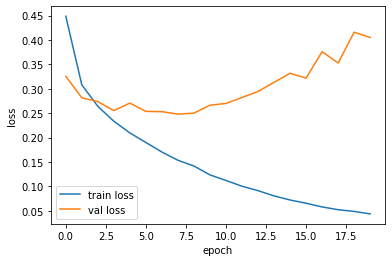

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

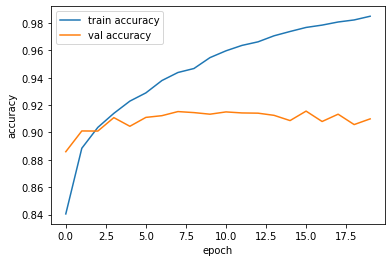

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [40]:
from tensorflow.keras.layers import Dropout
conv2=tf.keras.Sequential()
conv2.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [41]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [42]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history=conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6708 - accuracy: 0.7570 - val_loss: 0.3532 - val_accuracy: 0.8754
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3838 - accuracy: 0.8571 - val_loss: 0.3213 - val_accuracy: 0.8843
Epoch 3/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3449 - accuracy: 0.8729 - val_loss: 0.2839 - val_accuracy: 0.8977
Epoch 4/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3110 - accuracy: 0.8849 - val_loss: 0.2709 - val_accuracy: 0.9039
Epoch 5/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2932 - accuracy: 0.8886 - val_loss: 0.2633 - val_accuracy: 0.9038
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2749 - accuracy: 0.8987 - val_loss: 0.2559 - val_accuracy: 0.9076
Epoch 7/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2637 - accuracy: 0.9021 - val_loss: 0.2458 - val_accuracy:

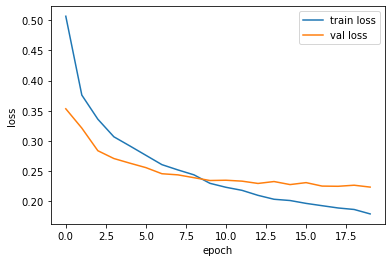

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

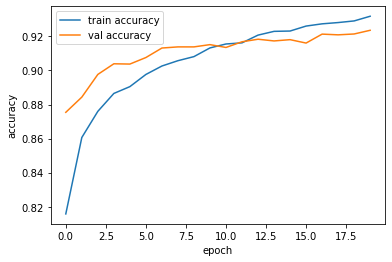

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()